# Run WITMaps for Macquarie Marshes. 
- 1. Maps for each timestep
- 2. For one event:
    calculate: 
        per-pixel!!!!!!!!
        -exceedence - eg. threshold each cloudmasked! timeslice (because if you don't have 100% cloudfree images then you'll get crazy noise)
        -Drop any pixel using xr.where where there is less than 100%. this should show what is still wet after 9, 7, 5, 3 ,1 months.
        
        potential issues - no observations in a given month - does this count as continuous or discontinuous>?
        
        

In [1]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
import seaborn as sns
from shapely import geometry
import sys
import xarray as xr

from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from textwrap import wrap

from datacube.storage import masking
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from digitalearthau.utils import wofs_fuser

sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools, WetlandsTools, SpatialTools, wetlands_insight

dc = datacube.Datacube(app='wetlands insight tool')
%load_ext autoreload
%autoreload 2

In [2]:
#path to hydrograph data
flowdata = '/g/data/r78/rjd547/CEWO_Project/Data/flow_data_mac_marsh_2018/FlowData.xlsx'

In [3]:
#set output directory
global Output_dir
Output_dir = '/g/data/r78/rjd547/CEWO_Project/prototyping_outputs/'

In [4]:
#set polygon path
poly_path='/g/data/r78/rjd547/Ramsar_Wetlands/shapefiles/ExplodedRAMSAR.shp'

In [5]:
with fiona.open(poly_path) as shapes:
    #get crs object from polygon file
    crs = geometry.CRS(shapes.crs_wkt)
    for feature in shapes:
        #print (feature['id'])
        if feature['id'] == str(94): #matching this because I know the number for mac marshes
            #get feature geometry
            feature_geometry=feature['geometry']
            polyname =WetlandsTools.get_RAMSAR_polyName(feature)
            #print(polyname)
            #create datacube geometry.Geometry object
            geom = geometry.Geometry(feature_geometry, crs=crs)
            query = {'geopolygon': geom}#, 'time': ('2001-01-01', '2003-01-01') }# this should run for all time, if there is no time set?
            #load and mask data. selecting data with more than 90% clear for the geobox around the polygon... #FIXME

processing polygon The_Macquarie_Marshes-Macquarie_Marshes_Nature_Reserve-NSW-94


In [6]:
# get the bounding box around the polygon in order to plot our area of interest
feature_bounding_box = geometry.Geometry(feature_geometry, crs=crs).boundingbox

In [7]:
gauge_data = pd.read_excel(flowdata, 
                        sheet_name='Sheet1', 
                        header=(2), 
                        usecols=('Date','Flow','NSWEW','CEW'),
                        index_col='Date',
                        parse_dates=True
                        )

In [8]:
#convert flow data to xarray
flow_data=gauge_data.to_xarray()

In [9]:
query = {'geopolygon': geom,
         #'time': (gauge_data.index[0], gauge_data.index[-1]) #get first and last times for our query from original xlsx
         'time':('2019-01-01', '2019-06-01'), 
         }

In [10]:
WITmaps = wetlands_insight.WIT_da(query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 6 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 6 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


## plot WIT maps for the timeseries.

In [11]:
#usng an appropriate palette
pal_opt = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["brown"],  
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"]]

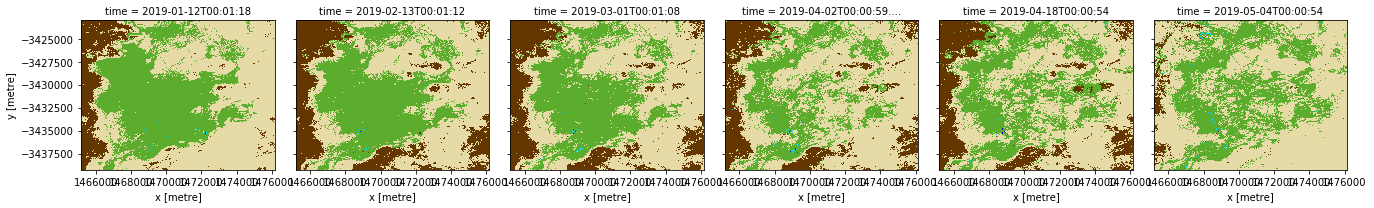

In [12]:
WITmaps.plot(col='time', col_wrap=6,vmin = 0, vmax = 4.01, levels=6, colors = pal_opt, add_colorbar=False)#,figsize=(8,12))
plt.show()

In [13]:
monthWIT=WITmaps.resample(time='MS', skipna=True, keep_attrs=True, restore_coord_dims=True).mean('time')

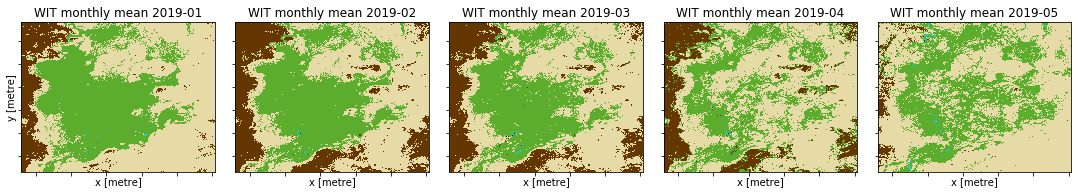

In [14]:
#plt.clf()
plotwit=monthWIT.plot(col='time', col_wrap=5,vmin = 0, vmax = 4.01, levels=6, colors = pal_opt, add_colorbar=False)#,figsize=(8,12))

for i,ax in enumerate(plotwit.axes.flat):
        ax.set_title(f'WIT monthly mean {str(monthWIT.isel(time=i).time.data)[0:7]}')
        ax.tick_params(which = 'both', labelbottom = False,labelleft = False)
        if ax==2:
            ax.set_xlabel(f'The Fractional Cover algorithm developed by the Joint Remote'
            f' Sensing Research Program and \n the Water Observations from Space algorithm '
            f'developed by Geoscience Australia are used in the production of this data',style='italic')

plt.savefig('/g/data/r78/rjd547/CEWO_Project/prototyping_outputs/MacMarsh.png')
plt.show()


In [36]:
query = {'geopolygon': geom,
         #'time': (gauge_data.index[0], gauge_data.index[-1]) #get first and last times for our query from original xlsx
        # 'time':('2018-01-01', '2019-11-01'), 
         }

In [ ]:
WITplots=wetlands_insight.WIT_array(query)

Loading ls5
    Loading 274 filtered ls5 timesteps


In [ ]:
WITplots

In [ ]:
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]  

In [ ]:
import matplotlib.pyplot as plt
#make a stacked area plot
plt.clf()
fig= plt.figure(figsize = (12,4))
plt.stackplot(WITplots.water.time.values, 
              WITplots.water, 
              WITplots.wet, 
              WITplots.green, 
              WITplots.dry,
              WITplots.bare,
              labels=['water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal, alpha = 0.6)


#set axis limits to the min and max
plt.axis(xmin = WITplots.water.time[0].data, xmax = WITplots.water.time[-1].data, ymin = 0, ymax = 100)

#add a legend and a tight plot box
plt.legend(loc='lower left', framealpha=0.6)
#plt.tight_layout()

#create rectangle borders for no-data times (SLC-off only)
LS5_8_gap_start = datetime(2011,11,1)
LS5_8_gap_end = datetime(2013,4,1)

# convert to matplotlib date representation
gap_start = mdates.date2num(LS5_8_gap_start)
gap_end = mdates.date2num(LS5_8_gap_end)
gap = gap_end - gap_start


#set date ticks every year
#years = mdates.YearLocator(2)
#yearsFmt = mdates.DateFormatter('%Y')
ax = plt.gca()
#ax.xaxis.set_major_locator(years)
#ax.xaxis.set_major_formatter(yearsFmt)
#ax.yaxis.set_ticks(np.arange(0,110,10))
ax.set_xlabel(f'The Fractional Cover algorithm developed by the Joint Remote'
f' Sensing Research Program and \n the Water Observations from Space algorithm '
f'developed by Geoscience Australia are used in the production of this data',style='italic')


#set up rectangle
slc_rectangle= Rectangle((gap_start,0), gap, 100,alpha = 0.5, facecolor=sns.xkcd_rgb['white'],
             edgecolor=sns.xkcd_rgb['white'], hatch="////",linewidth=2)
ax.add_patch(slc_rectangle)
fig.autofmt_xdate()


polyName='Macquarie Marshes'

polyName=polyName.replace("'","\\'")
title=ax.set_title("\n".join(wrap(f'Percentage of area WOfS, Wetness, Fractional Cover for {polyName}')))
fig.tight_layout()
title.set_y(1.05)

#save the figure
#4plt.savefig(f'{Output_dir}{polyName}.png')#, transparent=True)
plt.show()
print(f'plot created for {polyName}')

In [ ]:
flow_data

In [ ]:
some_flow = flow_data.where(flow_data.CEW >0)

In [ ]:
#matplotlib needs asome_flow of help to plot years, months, days
plt.clf()
flow_data.Flow.plot.line(figsize=(15,5))
some_flow.Flow.plot.line()
flow_data.CEW.plot.line()
#plt.axis(xmin = gauge_data['Flow'].time[0].data, xmax = gauge_data['Flow'].time[-1].data)
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%m')
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
plt.show()

In [ ]:
(some_flow.CEW).plot.line()

In [ ]:
## Dates of start 
bool_flow = xr.ufuncs.isfinite(flow_data.where(flow_data.CEW >0))
flow_IO = bool_flow.astype(int)

In [ ]:
plt.plot(flow_IO.Date, flow_IO.CEW)
plt.tight_layout()

## try and get end of environmental watering event

In [ ]:
end_event=flow_IO.CEW.where(flow_IO.CEW > flow_IO.CEW) 

In [ ]:
end_event.max()

In [ ]:
flow_IO

In [ ]:
plt.plot(end_event.Date, end_event)
plt.tight_layout()